In [1]:
import cv2
import numpy as np

import matplotlib.pyplot as plt

In [2]:
def create_gaussian_kernel():
    """
    Create the Gaussian kernel h = [1 4 6 4 1]/16 
    """
    return np.array([1, 4, 6, 4, 1]) / 16.0

def apply_gaussian_filter(image):
    """
    Apply Gaussian filtering using the specified kernel
    """
    kernel = create_gaussian_kernel()
    if len(image.shape) == 3:
        filtered = np.zeros_like(image)
        for i in range(3):
            filtered[:,:,i] = cv2.sepFilter2D(image[:,:,i], -1, kernel, kernel)
        return filtered
    return cv2.sepFilter2D(image, -1, kernel, kernel)

def generate_gaussian_pyramid(image, levels):
    """
    Generate Gaussian pyramid with L+1 levels
    """
    pyramid = [image]
    current = image.copy()
    for _ in range(levels):
        filtered = apply_gaussian_filter(current)
        current = filtered[::2, ::2]
        pyramid.append(current)
    return pyramid

def generate_laplacian_pyramid(image, levels):
    """
    Generate Laplacian pyramid with L+1 levels
    """
    gaussian_pyramid = generate_gaussian_pyramid(image, levels)
    pyramid = []
    
    for i in range(levels):
        current = gaussian_pyramid[i]
        next_level = gaussian_pyramid[i + 1]
        expanded = cv2.resize(next_level, (current.shape[1], current.shape[0]))
        laplacian = current - expanded
        pyramid.append(laplacian)
    
    pyramid.append(gaussian_pyramid[-1])
    return pyramid

def create_mask(shape):
    """
    Create a binary mask dividing the image vertically
    """
    mask = np.zeros(shape[:2])
    mask[:, :shape[1]//2] = 1
    return mask

def blend_pyramids(pyr1, pyr2, mask_pyr):
    """
    Blend pyramids according to equation (4) 
    """
    blended_pyr = []
    
    for i in range(len(pyr1)-1):
        mask = np.expand_dims(mask_pyr[i], axis=2) if len(pyr1[i].shape) == 3 else mask_pyr[i]
        blended = mask * pyr1[i] + (1 - mask) * pyr2[i]
        blended_pyr.append(blended)
    
    mask = np.expand_dims(mask_pyr[-1], axis=2) if len(pyr1[-1].shape) == 3 else mask_pyr[-1]
    last_level = mask * pyr1[-1] + (1 - mask) * pyr2[-1]
    blended_pyr.append(last_level)
    
    return blended_pyr

def reconstruct_from_pyramid(pyramid):
    """
    Reconstruct image from pyramid
    """
    current = pyramid[-1]
    
    for level in reversed(pyramid[:-1]):
        expanded = cv2.resize(current, (level.shape[1], level.shape[0]))
        current = expanded + level
    
    return current

In [3]:
def display_pyramid(pyramid, title):
    """
    Display all levels of a pyramid
    """
    plt.figure(figsize=(20, 4))
    for i, level in enumerate(pyramid):
        plt.subplot(1, len(pyramid), i+1)
        if len(level.shape) == 3:
            plt.imshow(np.clip(level, 0, 1))
        else:
            plt.imshow(level, cmap='gray')
        plt.title(f'Level {i}')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

In [4]:
def create_direct_blend(img1, img2, mask):
    """
    Create direct blend without pyramid blending
    """
    mask = np.expand_dims(mask, axis=2)
    return img1 * mask + img2 * (1 - mask)

In [13]:
# Read images
try:
    apple = cv2.imread('photos/apple.jpg')
    orange = cv2.imread('photos/orange.jpg')

    if apple is None or orange is None:
        raise FileNotFoundError("Could not read one or both images")

except Exception as e:
    print(f"Error loading images: {e}")
    exit()

# Convert from BGR to RGB and normalize
apple = cv2.cvtColor(apple, cv2.COLOR_BGR2RGB).astype(float) / 255
orange = cv2.cvtColor(orange, cv2.COLOR_BGR2RGB).astype(float) / 255

# Verify images are the same size
if apple.shape != orange.shape:
    print(f"Images must be the same size. Got apple: {apple.shape}, orange: {orange.shape}")
    exit()

# Number of pyramid levels
L = 5

# Create mask and its Gaussian pyramid
mask = create_mask(apple.shape)
mask_pyramid = generate_gaussian_pyramid(mask, L)



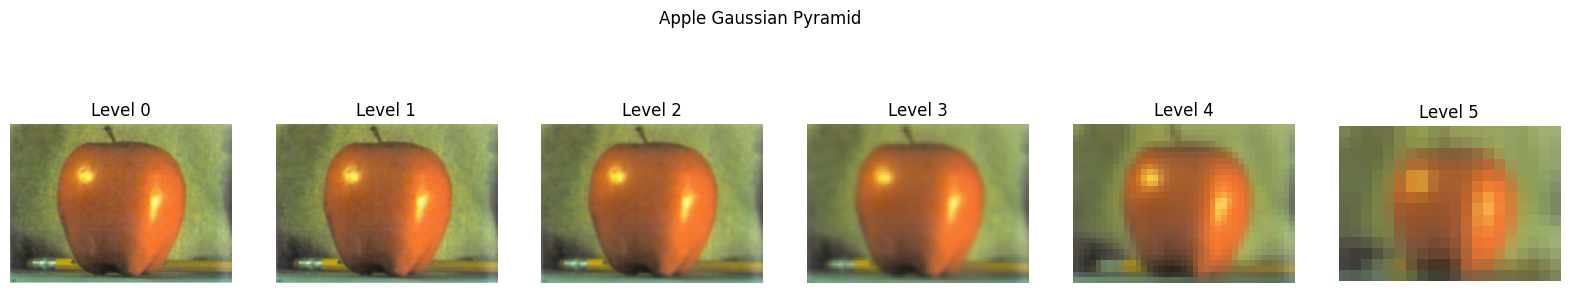

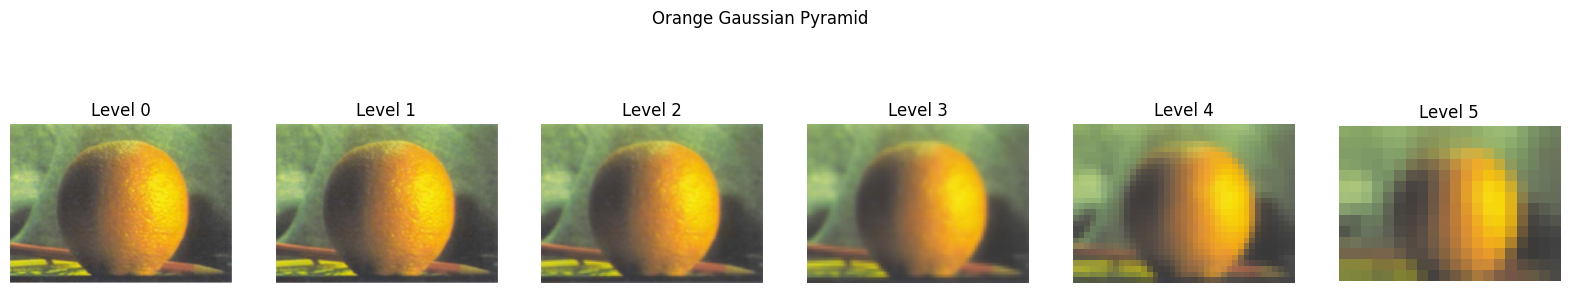

In [12]:
# Generate Gaussian pyramids for both images
apple_gaussian_pyramid = generate_gaussian_pyramid(apple, L)
orange_gaussian_pyramid = generate_gaussian_pyramid(orange, L)

# Display Gaussian pyramids
display_pyramid(apple_gaussian_pyramid, 'Apple Gaussian Pyramid')
display_pyramid(orange_gaussian_pyramid, 'Orange Gaussian Pyramid')



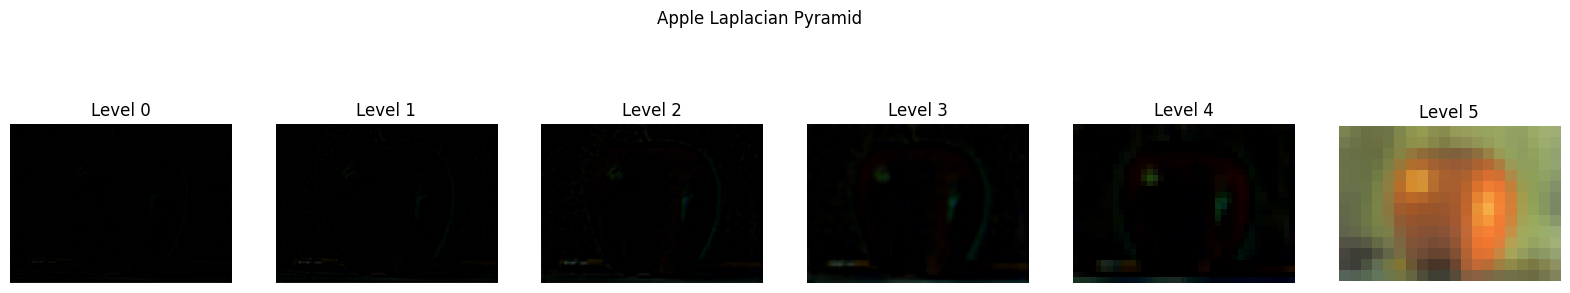

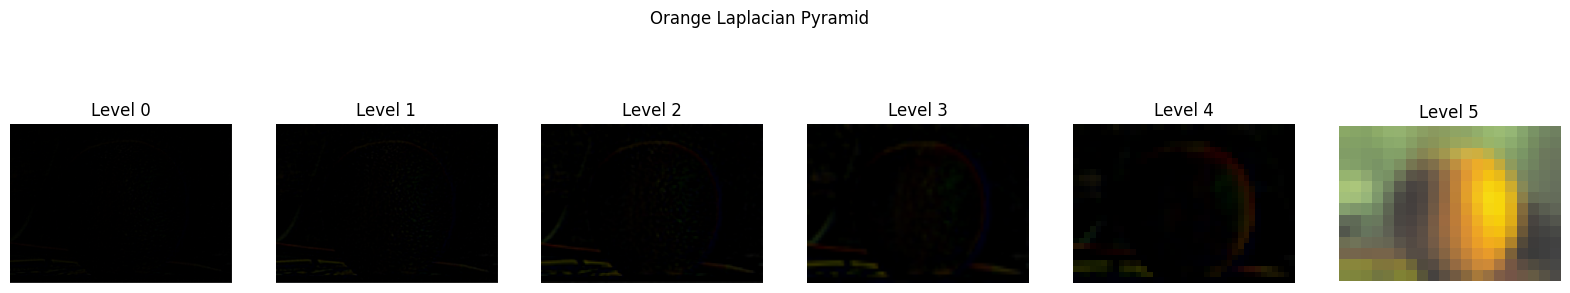

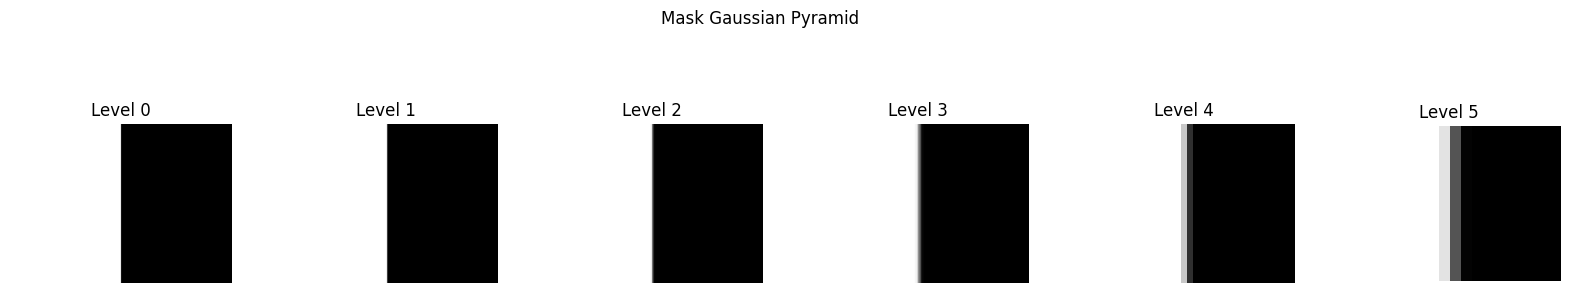

In [7]:
# Generate Laplacian pyramids for both images
apple_pyramid = generate_laplacian_pyramid(apple, L)
orange_pyramid = generate_laplacian_pyramid(orange, L)

# Display Laplacian pyramids
display_pyramid(apple_pyramid, 'Apple Laplacian Pyramid')
display_pyramid(orange_pyramid, 'Orange Laplacian Pyramid')
display_pyramid(mask_pyramid, 'Mask Gaussian Pyramid')


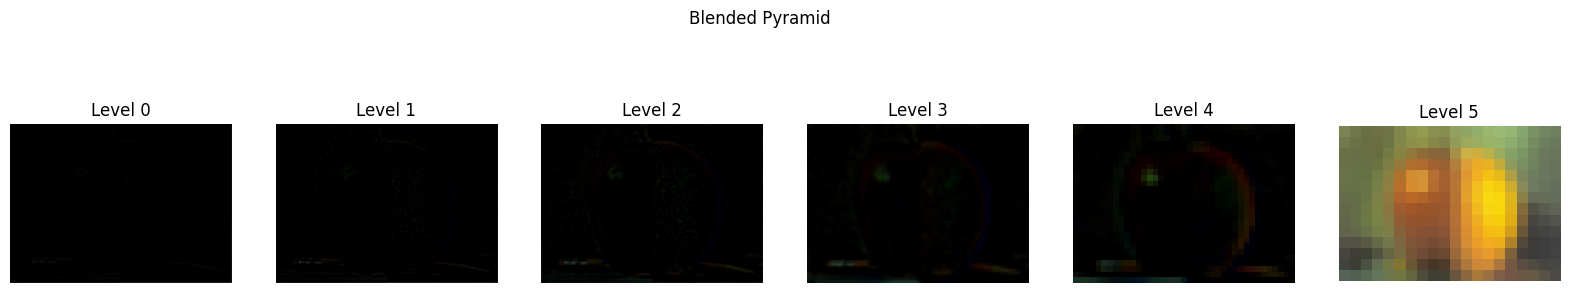

In [8]:
# Blend pyramids
blended_pyramid = blend_pyramids(apple_pyramid, orange_pyramid, mask_pyramid)
display_pyramid(blended_pyramid, 'Blended Pyramid')



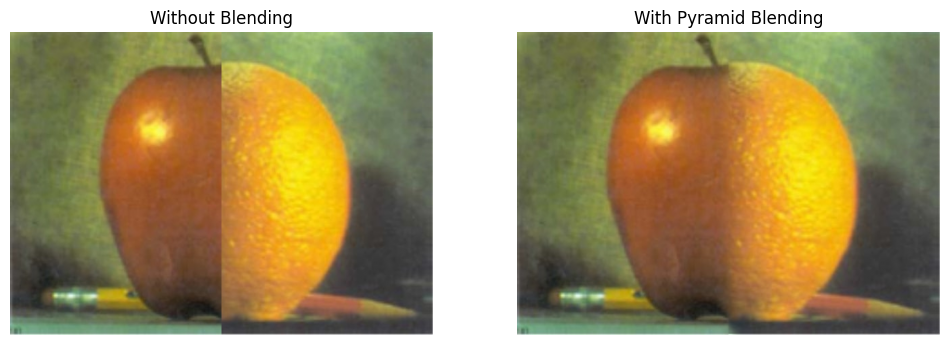

In [9]:
# Reconstruct the blended image
pyramid_blend = reconstruct_from_pyramid(blended_pyramid)

# Clip values to [0, 1] range
pyramid_blend = np.clip(pyramid_blend, 0, 1)

# Display final results
plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.imshow(create_direct_blend(apple, orange, mask))
plt.title('Without Blending')
plt.axis('off')

plt.subplot(122)
plt.imshow(pyramid_blend)
plt.title('With Pyramid Blending')
plt.axis('off')

plt.show()